## CA03 - Decision Tree Algorithm Overview
The purpose of this project is to use the decision tree algortihm in order to be able to predict the income category based on demographic features.

We will start with a basic Data Quality report followed by any necessary transformations and encoding. Then, we can move on to implementing the decision tree algorithm and tuning it in order to optimize the performance. 

We will finish by visualizing our model using graphviz and utilizing it for predictive analytics. 

## Data Source and Contents
The dataset we are using for this project is from the Census Bureau and contains salaries of seven different demographic categories. 

• Number of target classes: 2 ('>50K' and '<=50K') [ Labels: 1, 0 ]

• Number of attributes (Columns): 7

• Number of instances (Rows): 48,842



In [1]:
# Importing and installing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from autoviz.AutoViz_Class import AutoViz_Class
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.datasets import load_iris


!pip install graphviz
import graphviz



Imported v0.1.804. After importing autoviz, you must run '%matplotlib inline' to display charts inline.
    AV = AutoViz_Class()
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


In [2]:
df = pd.read_csv('https://github.com/ArinB/MSBA-CA-03-Decision-Trees/blob/master/census_data.csv?raw=true')

# Save a Copy
data = df.to_csv('census-data.csv', index=False)


# Initial Observation of df architecture and types
df.head(10)


,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,b. 31-40,b. Mid - Low,b. Mid,c. > 0,c. High,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60,train,0
1,a. 0-30,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,0
2,b. 31-40,a. Low,b. Mid,a. = 0,c. High,b. 9-12,b. Mid,b. income,d. 36-40 & 56-60,train,0
3,b. 31-40,a. Low,c. High,a. = 0,b. Mid,a. 0-8,a. Low,b. income,e. 40-55,train,0
4,b. 31-40,e. High,c. High,a. = 0,a. Low,c. 13,c. Bachelors,b. income,b. 26-30 & 71-100,train,0
5,b. 31-40,e. High,c. High,a. = 0,b. Mid,d. 14,d. Masters,b. income,d. 36-40 & 56-60,train,0
6,a. 0-30,a. Low,b. Mid,a. = 0,a. Low,a. 0-8,a. Low,b. income,e. 40-55,train,0
7,d. 41-50 & 61-70,e. High,c. High,a. = 0,c. High,b. 9-12,b. Mid,b. income,e. 40-55,train,1
8,d. 41-50 & 61-70,e. High,b. Mid,c. > 0,b. Mid,d. 14,d. Masters,b. income,c. 31-35 & 61-70,train,1
9,b. 31-40,e. High,c. High,c. > 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,1


## Data Quality Analysis

Here we used Autoviz to create a quick overview of what potential data quality issues there might be and where they might be occuring. From the report, at a first glance there doesnt seem to be any major issues although further testing will be required to ensue this is the case. 

The report shows that there are 40,012 duplicate rows within our dataframe, but this makes sense given the nature of the data and hence they will not be removed. 

Shape of your Data Set loaded: (48842, 11)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
  Printing upto 30 columns (max) in each category:
    Numeric Columns : []
    Integer-Categorical Columns: []
    String-Categorical Columns: ['hours_per_week_bin', 'occupation_bin', 'msr_bin', 'capital_gl_bin', 'race_sex_bin', 'education_num_bin', 'education_bin', 'age_bin']
    Factor-Categorical Columns: []
    String-Boolean Columns: ['workclass_bin', 'flag']
    Numeric-Boolean Columns: ['y']
    Discrete String Columns: []
    NLP text Columns: []
    Date Time Columns: []
    ID Columns: []
    Columns that will not be considered in modeling: []
    11 Predictors classified...
        No variables removed since no ID or low-information var

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
hours_per_week_bin,object,0.000000,0,,,No issue
occupation_bin,object,0.000000,0,,,No issue
msr_bin,object,0.000000,0,,,No issue
capital_gl_bin,object,0.000000,0,,,No issue
race_sex_bin,object,0.000000,0,,,No issue
education_num_bin,object,0.000000,0,,,No issue
education_bin,object,0.000000,0,,,No issue
workclass_bin,object,0.000000,0,,,No issue
age_bin,object,0.000000,0,,,No issue
flag,object,0.000000,0,,,No issue


Could not draw catscatter plots...
All Plots are saved in ./AutoViz_Plots/AutoViz
Time to run AutoViz = 3 seconds 


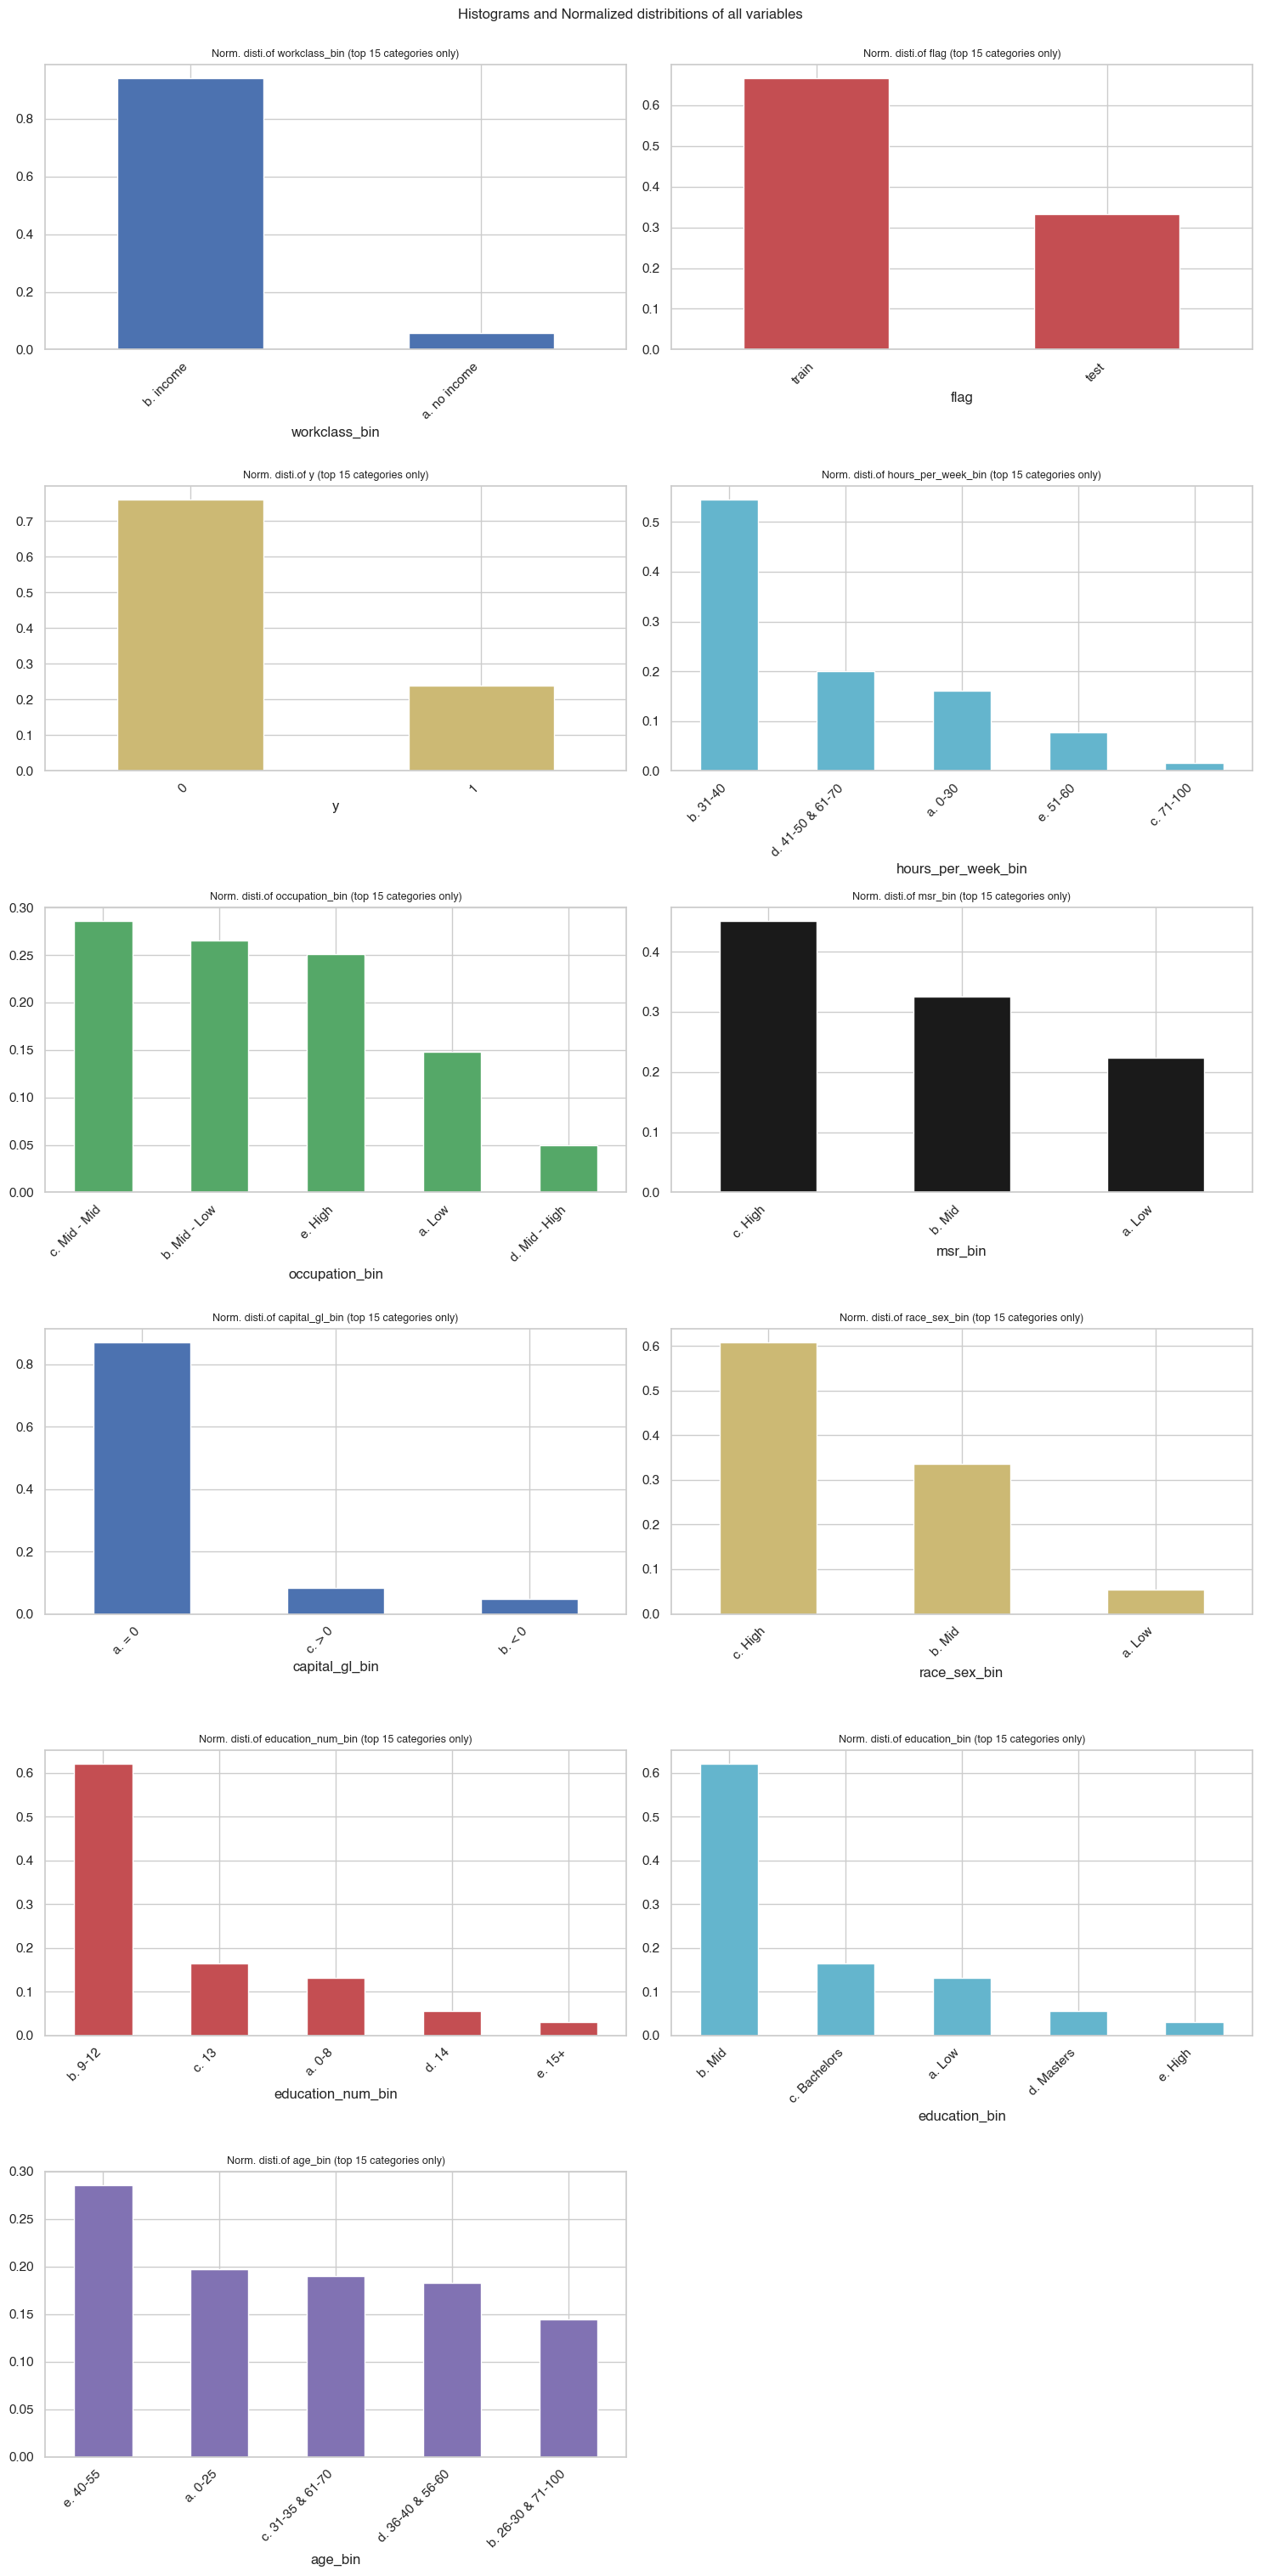

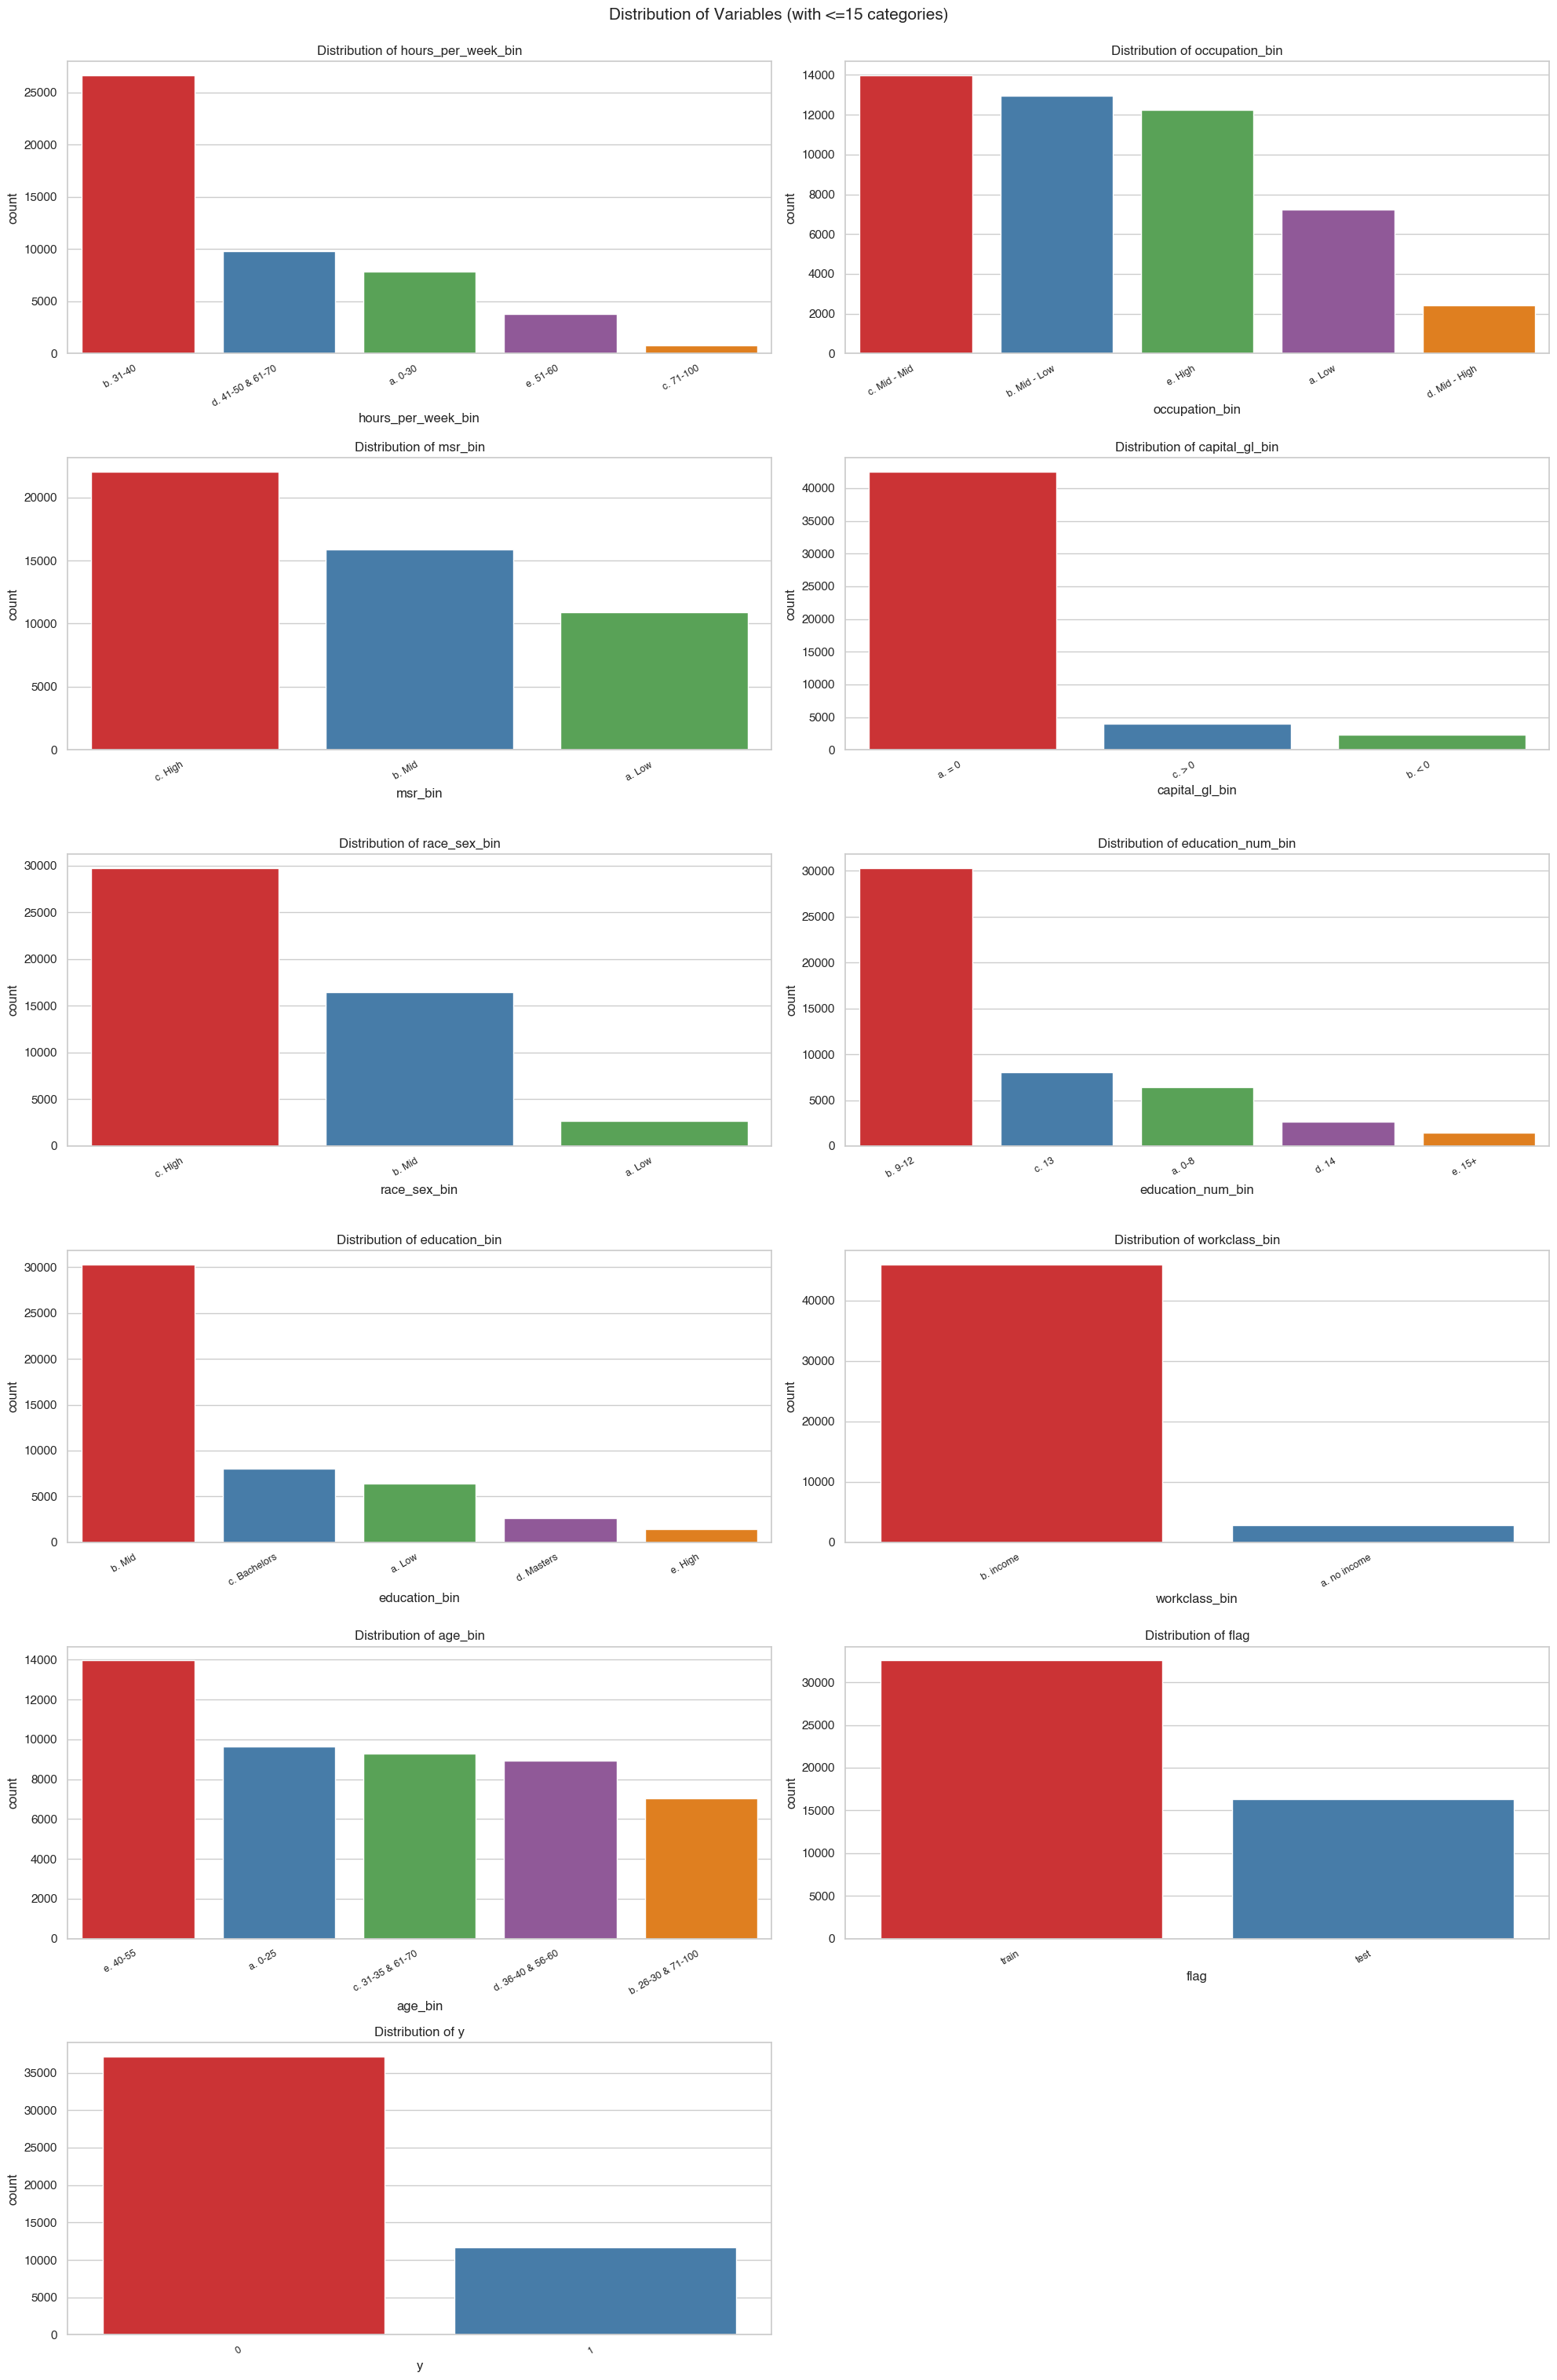

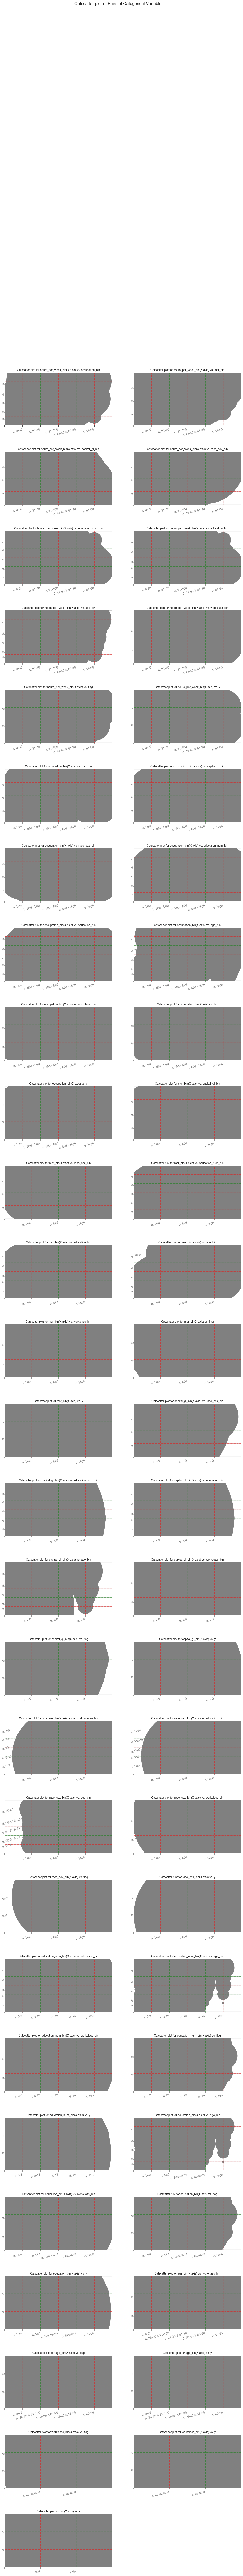

In [3]:

# Instantiate the AutoViz class
AV = AutoViz_Class()

# Showing the plots inline
%matplotlib inline

viz_report = AV.AutoViz(
    filename="",  
    sep=",",      
    depVar="",    
    dfte=df,      
    header=0,
    verbose=2
)


## Data Cleaning and Transformations 
Although there werent any major data cleaning issues to take on, we still have to encode the categorical variables to be used in the decision tree algorithm. 

In [4]:
# Identifying categorical columns (excluding 'flag' and 'y' which are not features)
categorical_features = df.select_dtypes(include=['object']).columns.drop(['flag'])

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Encode the categorical features
encoded_features = pd.DataFrame(encoder.fit_transform(df[categorical_features]), 
                                columns=encoder.get_feature_names_out(categorical_features))

# Combine encoded features with the rest of the dataset (excluding original categorical features)
df = df.drop(categorical_features, axis=1).join(encoded_features)

df.head(20)

,flag,y,hours_per_week_bin_a. 0-30,hours_per_week_bin_b. 31-40,hours_per_week_bin_c. 71-100,hours_per_week_bin_d. 41-50 & 61-70,hours_per_week_bin_e. 51-60,occupation_bin_a. Low,occupation_bin_b. Mid - Low,occupation_bin_c. Mid - Mid,occupation_bin_d. Mid - High,occupation_bin_e. High,msr_bin_a. Low,msr_bin_b. Mid,msr_bin_c. High,capital_gl_bin_a. = 0,capital_gl_bin_b. < 0,capital_gl_bin_c. > 0,race_sex_bin_a. Low,race_sex_bin_b. Mid,race_sex_bin_c. High,education_num_bin_a. 0-8,education_num_bin_b. 9-12,education_num_bin_c. 13,education_num_bin_d. 14,education_num_bin_e. 15+,education_bin_a. Low,education_bin_b. Mid,education_bin_c. Bachelors,education_bin_d. Masters,education_bin_e. High,workclass_bin_a. no income,workclass_bin_b. income,age_bin_a. 0-25,age_bin_b. 26-30 & 71-100,age_bin_c. 31-35 & 61-70,age_bin_d. 36-40 & 56-60,age_bin_e. 40-55
0,train,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,train,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,train,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,train,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,train,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
5,train,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6,train,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7,train,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
8,train,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9,train,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## Decision Tree Classifier Models
First, we have to split the data into test and training data based on the given flag column. Then, we can create variables for the testing and training data. 

Finally, we can initialize the decision tree classifier and fit the model on the training data and make predicitons based on the test data. 

In [5]:
# Now we need to split the data into training and testing sets based on the 'flag' column
train_data = df[df['flag'] == 'train'].drop('flag', axis=1)
test_data = df[df['flag'] == 'test'].drop('flag', axis=1)

# Separating features and target variable for training and testing data
X_train = train_data.drop('y', axis=1)
y_train = train_data['y']

X_test = test_data.drop('y', axis=1)
y_test = test_data['y']

# Initializing the DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42)

# Fitting the model on the training data
clf.fit(X_train, y_train)

# Making predictions on the test data
y_pred = clf.predict(X_test)

## Decision Tree Performance
Now we can check the performance of the model. Here we check the accuracy, recall, precision, f1-score, and confusion matrix to get an idea of how the model is performing. 

In [6]:
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Displaying the metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


Accuracy: 0.84
Precision: 0.69
Recall: 0.55
F1 Score: 0.61


In [7]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

,Predicted 0,Predicted 1
Actual 0,11486,949
Actual 1,1721,2125


## Decision Tree Tuning


In [8]:
#### RUN 1

# Define a function to perform the training and evaluation
def train_evaluate_decision_tree(criterion, min_samples_leaf, max_features, max_depth, X_train, y_train, X_test, y_test):
    # Initialize the DecisionTreeClassifier with given hyperparameters
    clf = DecisionTreeClassifier(
        criterion=criterion,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        max_depth=max_depth,
        random_state=99
    )
    
    # Fit the model on the training data
    clf.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = clf.predict(X_test)
    
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# Define the hyperparameters for run 1
criteria = ['entropy', 'gini']
min_samples_leaf_values = [5, 10, 15, 20, 25, 30, 35, 40]
max_features = None  
max_depth = 2  # This will only be varied in the last run

# Store the results
results_run1 = []

# Conduct Run 1 - varying 'criterion' and 'min_samples_leaf'
for criterion in criteria:
    for min_samples_leaf in min_samples_leaf_values:
        accuracy = train_evaluate_decision_tree(
            criterion=criterion,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            max_depth=max_depth,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test
        )
        results_run1.append({
            'Criterion': criterion,
            'Min Samples Leaf': min_samples_leaf,
            'Accuracy': accuracy
        })

# Convert results to DataFrame
results_run1_df = pd.DataFrame(results_run1)

# Display the results DataFrame
results_run1_df


,Criterion,Min Samples Leaf,Accuracy
0,entropy,5,0.816596
1,entropy,10,0.816596
2,entropy,15,0.816596
3,entropy,20,0.816596
4,entropy,25,0.816596
5,entropy,30,0.816596
6,entropy,35,0.816596
7,entropy,40,0.816596
8,gini,5,0.816596
9,gini,10,0.816596


In [9]:
#### Run 2

# Define the best criterion from Run 1
best_criterion = 'gini'  

# Store the results for Run 2
results_run2 = []

# Define a range of 'min_samples_leaf' values to test
min_samples_leaf_values = [5, 10, 15, 20, 25, 30, 35, 40]

# Conduct Run 2 - varying 'min_samples_leaf' with the best criterion
for min_samples_leaf in min_samples_leaf_values:
    # We keep 'max_features' and 'max_depth' at their default values for this run
    accuracy = train_evaluate_decision_tree(
        criterion=best_criterion,
        min_samples_leaf=min_samples_leaf,
        max_features=None,  # Default value
        max_depth=None,  # Default value, meaning the tree can grow until all leaves are pure
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )
    results_run2.append({
        'Criterion': best_criterion,
        'Min Samples Leaf': min_samples_leaf,
        'Accuracy': accuracy
    })

# Convert results to DataFrame for Run 2
results_run2_df = pd.DataFrame(results_run2)

# Display the results DataFrame for Run 2
results_run2_df


,Criterion,Min Samples Leaf,Accuracy
0,gini,5,0.838523
1,gini,10,0.839998
2,gini,15,0.841902
3,gini,20,0.844051
4,gini,25,0.843314
5,gini,30,0.842332
6,gini,35,0.843069
7,gini,40,0.842454


In [10]:
# Store the results for Run 3
results_run3 = []

# Define a range of 'max_features' values to test as a fraction of the total
max_features_values = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# Conduct Run 3 - varying 'max_features' with the best 'min_samples_leaf'
for max_features in max_features_values:
    # We keep 'criterion' and 'max_depth' at their default values for this run
    accuracy = train_evaluate_decision_tree(
        criterion='gini',  # Based on previous results
        min_samples_leaf=20,  # Best value from Run 2
        max_features=max_features,  # Varying this parameter
        max_depth=None,  # Default value, meaning the tree can grow until all leaves are pure
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )
    results_run3.append({
        'Max Features': max_features,
        'Accuracy': accuracy
    })

# Convert results to DataFrame for Run 3
results_run3_df = pd.DataFrame(results_run3)

# Display the results DataFrame for Run 3
results_run3_df


,Max Features,Accuracy
0,0.3,0.843191
1,0.4,0.842884
2,0.5,0.844420
3,0.6,0.843130
4,0.7,0.844358
5,0.8,0.844358


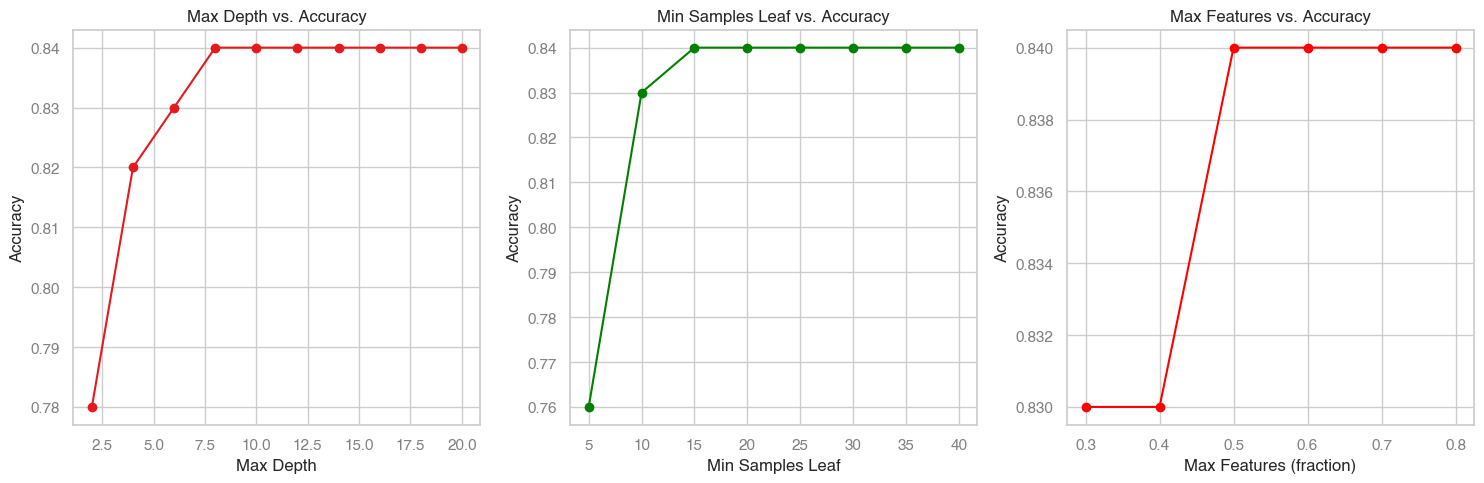

In [11]:
# Finding the best hyper-parameter value

max_depth_values = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
accuracies_max_depth = [0.78, 0.82, 0.83, 0.84, 0.84, 0.84, 0.84, 0.84, 0.84, 0.84]

min_samples_leaf_values = [5, 10, 15, 20, 25, 30, 35, 40]
accuracies_min_samples_leaf = [0.76, 0.83, 0.84, 0.84, 0.84, 0.84, 0.84, 0.84]

max_features_values = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
accuracies_max_features = [0.83, 0.83, 0.84, 0.84, 0.84, 0.84]

# Create line graphs
plt.figure(figsize=(15, 5))

# Max Depth vs. Accuracy
plt.subplot(1, 3, 1)
plt.plot(max_depth_values, accuracies_max_depth, marker='o')
plt.title('Max Depth vs. Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.grid(True)

# Min Samples Leaf vs. Accuracy
plt.subplot(1, 3, 2)
plt.plot(min_samples_leaf_values, accuracies_min_samples_leaf, marker='o', color='green')
plt.title('Min Samples Leaf vs. Accuracy')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Accuracy')
plt.grid(True)

# Max Features vs. Accuracy
plt.subplot(1, 3, 3)
plt.plot(max_features_values, accuracies_max_features, marker='o', color='red')
plt.title('Max Features vs. Accuracy')
plt.xlabel('Max Features (fraction)')
plt.ylabel('Accuracy')
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


In [12]:
# Define the best 'max_features' from Run 3
best_max_features = 0.5

# Store the results for Run 4
results_run4 = []

# Define a range of 'max_depth' values to test
max_depth_values = [2, 4, 6, 8, 10, 12, 14, 16]

# Conduct Run 4 - varying 'max_depth' with the best 'min_samples_leaf' and 'max_features'
for max_depth in max_depth_values:
    # We keep 'criterion' as 'gini' and 'min_samples_leaf' as 20 from the previous best results
    accuracy = train_evaluate_decision_tree(
        criterion='gini',  # Based on previous results
        min_samples_leaf=20,  # Best value from Run 2
        max_features=best_max_features,  # Best value from Run 3
        max_depth=max_depth,  # Varying this parameter
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )

    recall = train_evaluate_decision_tree(
        criterion='gini',  # Based on previous results
        min_samples_leaf=20,  # Best value from Run 2
        max_features=best_max_features,  # Best value from Run 3
        max_depth=max_depth,  # Varying this parameter
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )

    precision = train_evaluate_decision_tree(
        criterion='gini',  # Based on previous results
        min_samples_leaf=20,  # Best value from Run 2
        max_features=best_max_features,  # Best value from Run 3
        max_depth=max_depth,  # Varying this parameter
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )

    f1 = train_evaluate_decision_tree(
        criterion='gini',  # Based on previous results
        min_samples_leaf=20,  # Best value from Run 2
        max_features=best_max_features,  # Best value from Run 3
        max_depth=max_depth,  # Varying this parameter
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )
    results_run4.append({
        'Max Depth': max_depth,
        'Accuracy': accuracy,
        'Recall' : recall,
        'Precision' : precision,
        'F1 Score' : f1
    })

# Convert results to DataFrame for Run 4
results_run4_df = pd.DataFrame(results_run4)

# Display the results DataFrame for Run 4
results_run4_df


,Max Depth,Accuracy,Recall,Precision,F1 Score
0,2,0.790799,0.790799,0.790799,0.790799
1,4,0.829249,0.829249,0.829249,0.829249
2,6,0.838155,0.838155,0.838155,0.838155
3,8,0.840120,0.840120,0.840120,0.840120
4,10,0.843191,0.843191,0.843191,0.843191
5,12,0.844358,0.844358,0.844358,0.844358
6,14,0.844543,0.844543,0.844543,0.844543
7,16,0.844543,0.844543,0.844543,0.844543


In [13]:


clf = DecisionTreeClassifier(criterion='gini', min_samples_leaf=20, max_features=0.5, max_depth=14, random_state=42)

# Fitting the model on the training data
clf.fit(X_train, y_train)

# Making predictions on the test data
y_pred = clf.predict(X_test)

# Calculating metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Displaying the metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')



Accuracy: 0.84
Precision: 0.84
Recall: 0.84
F1 Score: 0.84


## Visualization of Best Decision Tree
Here, to visualize the decision tree, we used a python library called graphviz 

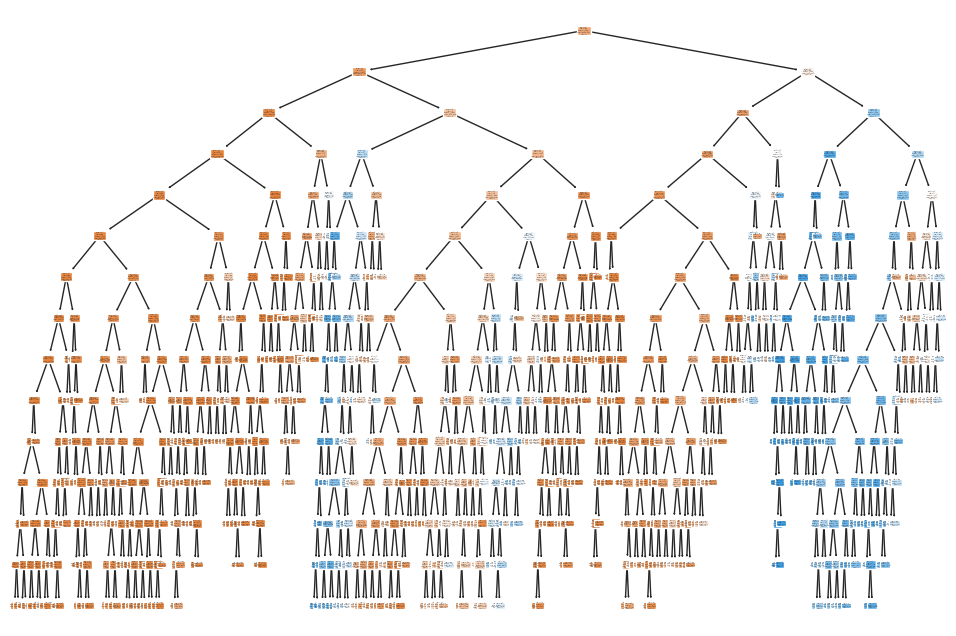

Time:  6.292277874999854


In [14]:
#  Best Tree
# Run 1 Gini
# Run 2 min samples leaf 20
# Run 3 max features 0.5
# run 4 Max Depth 8

import timeit

start = timeit.default_timer()

from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Assuming you have already prepared your training and testing sets as X_train, y_train, X_test, y_test
# And assuming you have a list of feature names called feature_names

# Initialize the DecisionTreeClassifier with the specified hyperparameters
clf = DecisionTreeClassifier(criterion='gini', min_samples_leaf=20, max_features=0.5, max_depth=14, random_state=42)

# Fit the classifier on the training data
clf.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(12,8)) # Set the size of the figure
plot_tree(clf, filled=True, class_names=['0', '1'])
plt.show()


stop = timeit.default_timer()

print('Time: ', stop - start)  

## Conclusion
It took only 6.4 seconds to train and plot

Not sure if we found the best tree because many numbers were very similar in terms of performance metrics

The best tree visualization is quite unreadable and unusable due to the depth of 14

The tree seems like it would likely overfit because of the depth of the tree. 

## Predictions Using Model


In [21]:

# Data for the new individual
new_individual_data = {
    'hours_per_week_bin': ['d. 41-50 & 61-70'],
    'occupation_bin': ['b. Mid - Low'],
    'msr_bin': ['c. High'],
    'capital_gl_bin': ['c. > 0'],  
    'race_sex_bin': ['b. Mid'],
    'education_num_bin': ['b. 9-12'],
    'education_bin': ['e. High'],
    'workclass_bin': ['b. income'],
    'age_bin': ['d. 36-40 & 56-60'],
}

# Convert the individual's data into a DataFrame
df = pd.DataFrame(new_individual_data)

df


,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin
0,d. 41-50 & 61-70,b. Mid - Low,c. High,c. > 0,b. Mid,b. 9-12,e. High,b. income,d. 36-40 & 56-60


In [26]:
# Identifying categorical columns (excluding 'flag' and 'y' which are not features)
categorical_features = df.select_dtypes(include=['object'])

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Encode the categorical features
encoded_features = pd.DataFrame(encoder.fit_transform(df[categorical_features]), 
                                columns=encoder.get_feature_names_out(categorical_features))

# Combine encoded features with the rest of the dataset (excluding original categorical features)
df = df.drop(categorical_features, axis=1).join(encoded_features)

df.head()

ValueError: Boolean array expected for the condition, not object

In [24]:
pred = clf.predict(df)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- age_bin
- capital_gl_bin
- education_bin
- education_num_bin
- hours_per_week_bin
- ...
Feature names seen at fit time, yet now missing:
- age_bin_a. 0-25
- age_bin_b. 26-30 & 71-100
- age_bin_c. 31-35 & 61-70
- age_bin_d. 36-40 & 56-60
- age_bin_e. 40-55
- ...
